# <center> __COMP7710 Cybersecurity Machine Learning Project__ </center>
### <center> __Intrusion Detection on the Edge-IIOT Dataset__ </center>
#### <center> Muhammad (Sulaman Khan) - 47511921 </center>

### __Import, Clean and Preprocess the Dataset__

In [402]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Ridge, Lasso, LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [416]:
# Read the dataset
df = pd.read_csv('dataset.csv')

In [178]:
df.head()

,frame.time,ip.src_host,ip.dst_host,arp.dst.proto_ipv4,arp.opcode,arp.hw.size,arp.src.proto_ipv4,icmp.checksum,icmp.seq_le,icmp.transmit_timestamp,...,mqtt.proto_len,mqtt.protoname,mqtt.topic,mqtt.topic_len,mqtt.ver,mbtcp.len,mbtcp.trans_id,mbtcp.unit_id,Attack_label,Attack_type
0,6.0,192.168.0.152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,MITM
1,6.0,192.168.0.101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,MITM
2,6.0,192.168.0.152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,MITM
3,6.0,192.168.0.101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,MITM
4,6.0,192.168.0.152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,MITM


In [417]:
# Drop NA and infinite values (doing becuase they did it in the paper)
df = df.replace([np.inf, -np.inf], np.nan)
df.dropna(inplace=True)

In [418]:
# Get attack names before encoding
attack_type_names = df['Attack_type'].astype('category').cat.categories

# Encode categorical features
le = LabelEncoder()

# Encode all object-type columns
for col in df.select_dtypes(include=['object']).columns:
    df[col] = le.fit_transform(df[col].astype(str))

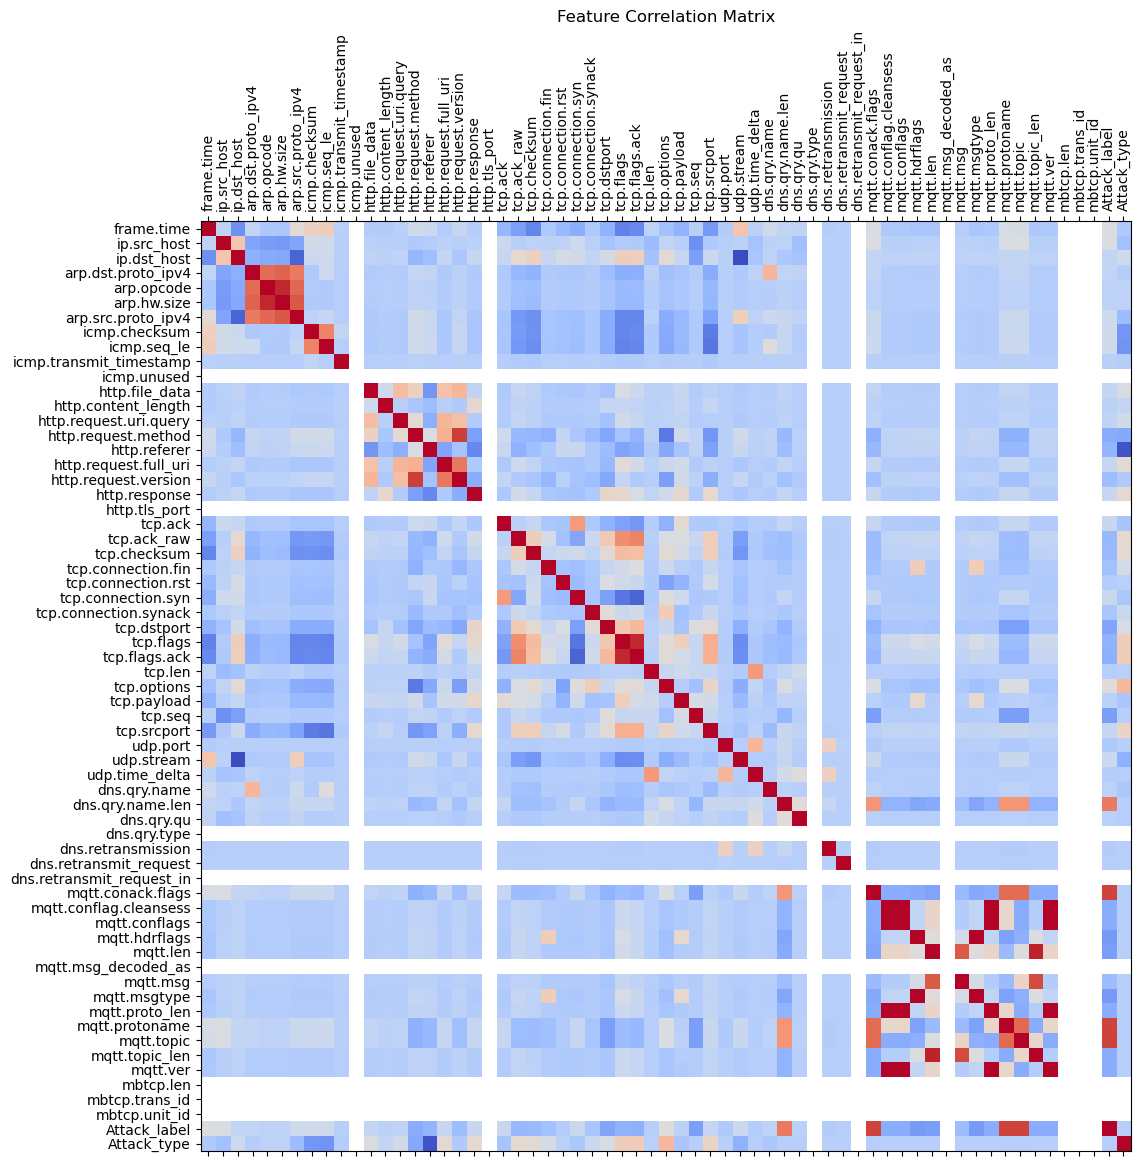

In [379]:
corr = df.corr()

# Plot
plt.figure(figsize=(15, 12))
plt.matshow(corr, fignum=1, cmap='coolwarm')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

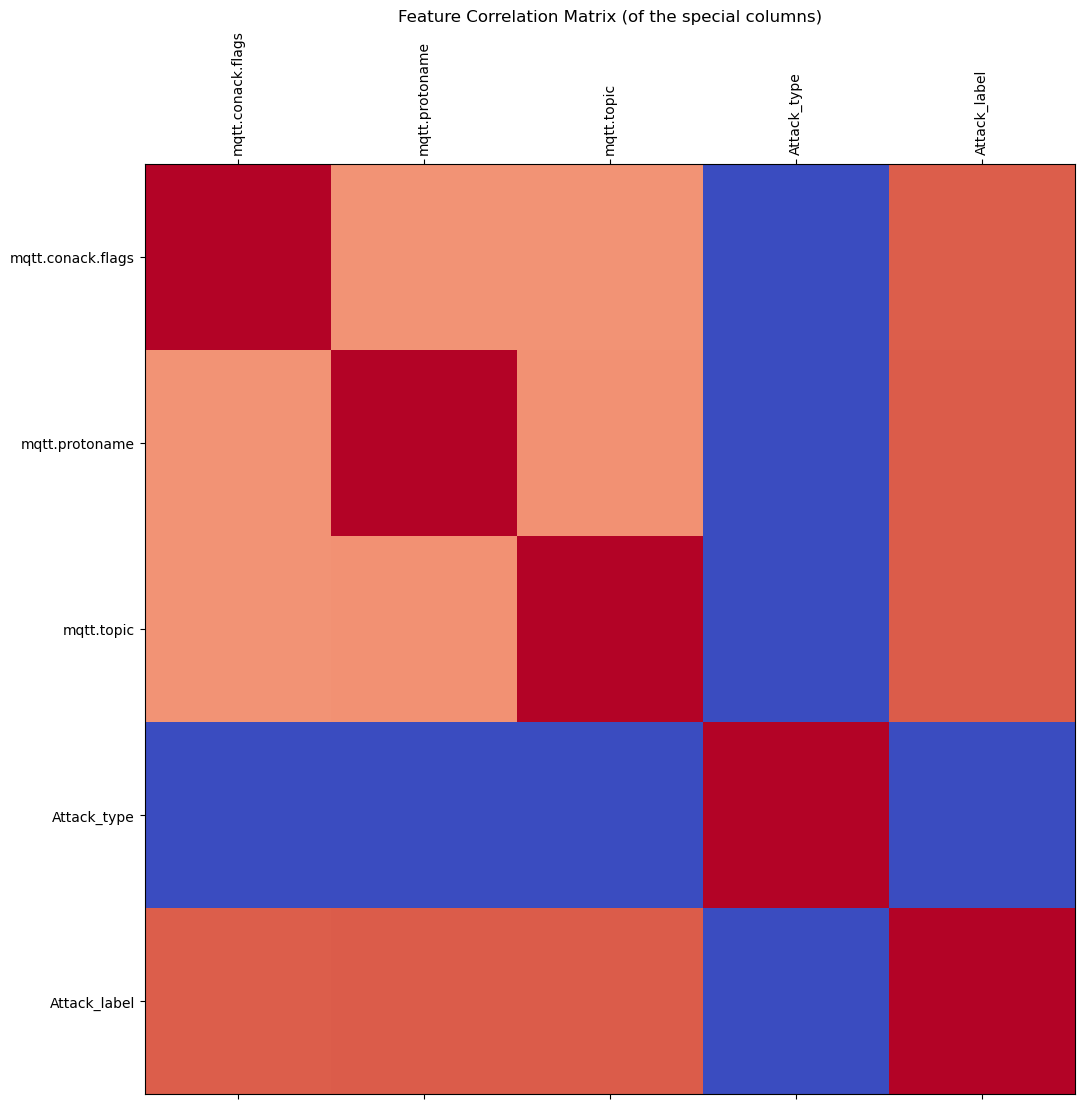

,mqtt.conack.flags,mqtt.protoname,mqtt.topic,Attack_type,Attack_label
mqtt.conack.flags,1.000000,0.761595,0.761959,-0.003600,0.878002
mqtt.protoname,0.761595,1.000000,0.765501,-0.003614,0.881600
mqtt.topic,0.761959,0.765501,1.000000,-0.003616,0.881969
Attack_type,-0.003600,-0.003614,-0.003616,1.000000,-0.004100
Attack_label,0.878002,0.881600,0.881969,-0.004100,1.000000


In [411]:
two = df[[ 'mqtt.conack.flags', 'mqtt.protoname', 'mqtt.topic', 'Attack_type', 'Attack_label']]

corr = two.corr()

# Plot
plt.figure(figsize=(15, 12))
plt.matshow(corr, fignum=1, cmap='coolwarm')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Feature Correlation Matrix (of the special columns)")
plt.tight_layout()
plt.show()

corr

In [415]:
for col in ['mqtt.conack.flags', 'mqtt.protoname', 'mqtt.topic', 'Attack_type', 'Attack_label']:
    print(f"\nUnique values in '{col}':")
    print(df[col].unique())


Unique values in 'mqtt.conack.flags':
[0.0 '0.0' '0' '0x00000000']

Unique values in 'mqtt.protoname':
[0.0 '0.0' '0' 'MQTT']

Unique values in 'mqtt.topic':
[0.0 '0.0' '0' 'Temperature_and_Humidity']

Unique values in 'Attack_type':
['MITM' 'Fingerprinting' 'Ransomware' 'Uploading' 'SQL_injection'
 'DDoS_HTTP' 'DDoS_TCP' 'Password' 'Port_Scanning' 'Vulnerability_scanner'
 'Backdoor' 'XSS' 'Normal' 'DDoS_UDP' 'DDoS_ICMP']

Unique values in 'Attack_label':
[1 0]


In [419]:
# Columns dropped in the paper
df.drop(columns=['frame.time', 'ip.src_host', 'ip.dst_host', 'arp.src.proto_ipv4',
                 'arp.dst.proto_ipv4', 'http.file_data' , 'http.request.full_uri',
                 'icmp.transmit_timestamp', 'http.request.uri.query', 'tcp.options',
                 'tcp.payload', 'tcp.srcport', 'tcp.dstport', 'udp.port', 'mqtt.msg']
        , inplace=True)

In [ ]:
# Columns dropped to lower performance
columns_to_drop = [
    # Make big difference to GMM performance for some reason
    # 'mqtt.topic',
    # 'mqtt.protoname',

    # Dont have a lot of impact, could drop
    # 'tcp.flags',
    # 'tcp.seq',
    # 'tcp.ack',
    # 'tcp.ack_raw',
    # 'tcp.len',
    # 'udp.time_delta',
    # 'mqtt.msgtype',
    # 'dns.qry.name',
    # 'http.request.method',
    # 'http.referer'
]

df.drop(columns=columns_to_drop, inplace=True)

In [420]:
X = df.drop(columns=['Attack_label', 'Attack_type'])

# Will vary the target variable to test accuracy of detecting the attack type
target_attack_label = False  # Change to True to use 'Attack_type' as target

if target_attack_label:
    y = df['Attack_label']
    attack_type_names = df['Attack_label'].astype('category').cat.categories
else:
    y = df['Attack_type']

In [421]:
scale = True

if scale:
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

In [422]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### __Simple Models (KNN, DT, LR)__

#### __Logistic Regression__

------ LOGISTIC REGRESSION MODEL ------
Accuracy: 0.7495


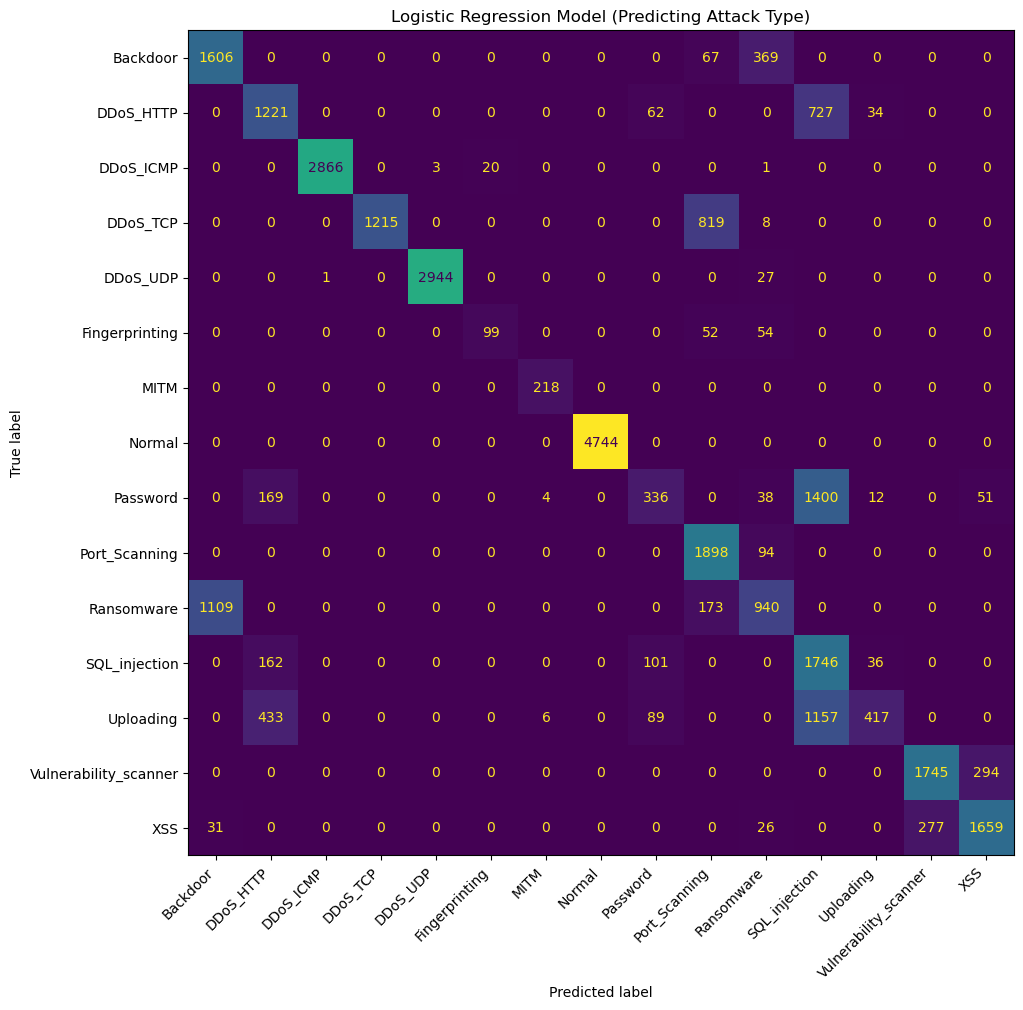

In [187]:
model = LogisticRegression()

model.fit(x_train, y_train)
pred = model.predict(x_test)
accuracy = accuracy_score(y_test, pred)

print("------ LOGISTIC REGRESSION MODEL ------")
print(f"Accuracy: {accuracy:.4f}")

if target_attack_label:
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    disp = ConfusionMatrixDisplay(confusion_matrix(
        y_test, pred), display_labels=attack_type_names)
    disp.plot(colorbar=False)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.title('Logisitic Regression Model (Predicting Attack Label)')
    plt.show()

else:
    disp = ConfusionMatrixDisplay(confusion_matrix(
        y_test, pred), display_labels=attack_type_names)
    fig, ax = plt.subplots(figsize=(12, 10))
    disp.plot(ax=ax, colorbar=False)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.title('Logistic Regression Model (Predicting Attack Type)')
    plt.show()

#### __K-Nearest Neighbors (KNN)__

------ K-NEAREST NEIGHBOURS MODEL ------
Accuracy: 0.7942


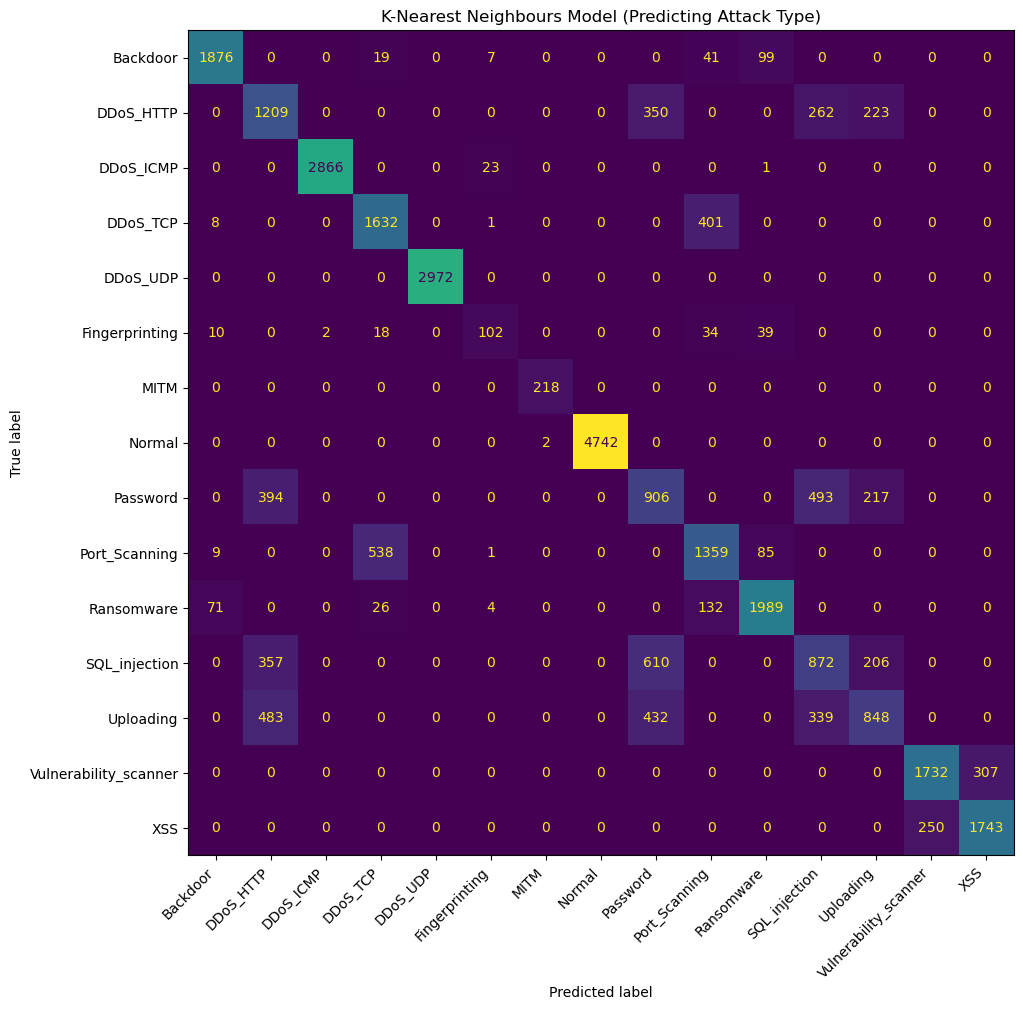

In [188]:
model = KNeighborsClassifier()

model.fit(x_train, y_train)
pred = model.predict(x_test)
accuracy = accuracy_score(y_test, pred)

print("------ K-NEAREST NEIGHBOURS MODEL ------")
print(f"Accuracy: {accuracy:.4f}")

if target_attack_label:
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    disp = ConfusionMatrixDisplay(confusion_matrix(
        y_test, pred), display_labels=attack_type_names)
    disp.plot(colorbar=False)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.title('K-Nearest Neighbours Model (Predicting Attack Label)')
    plt.show()

else:
    disp = ConfusionMatrixDisplay(confusion_matrix(
        y_test, pred), display_labels=attack_type_names)
    fig, ax = plt.subplots(figsize=(12, 10))
    disp.plot(ax=ax, colorbar=False)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.title('K-Nearest Neighbours Model (Predicting Attack Type)')
    plt.show()

k=1, Accuracy: 0.7929
k=2, Accuracy: 0.7789
k=3, Accuracy: 0.7933
k=4, Accuracy: 0.7899
k=5, Accuracy: 0.7942
k=6, Accuracy: 0.7902
k=7, Accuracy: 0.7922
k=8, Accuracy: 0.7907
k=9, Accuracy: 0.7928
k=10, Accuracy: 0.7911
k=11, Accuracy: 0.7939
k=12, Accuracy: 0.7894
k=13, Accuracy: 0.7914
k=14, Accuracy: 0.7886


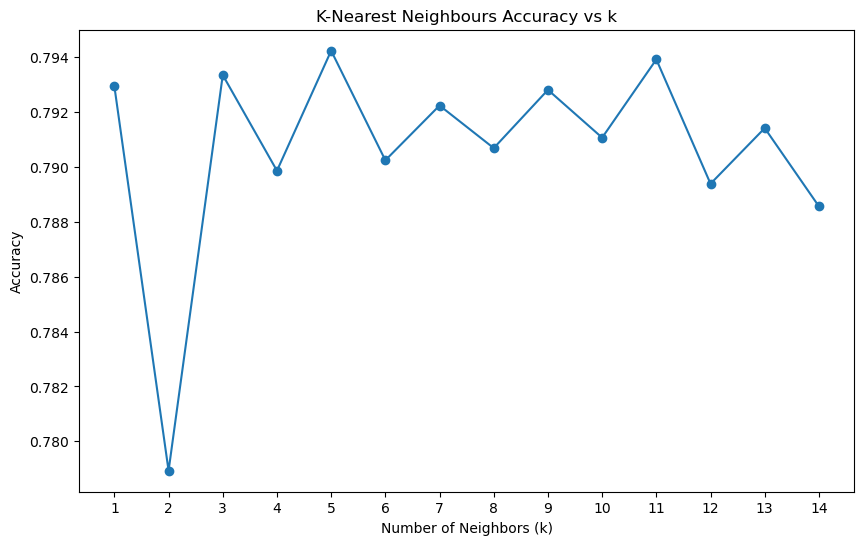

In [189]:
ks = range(1, 15)
accuracies = []

for k in ks:

    model = KNeighborsClassifier(n_neighbors=k)

    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, pred)
    accuracies.append(accuracy)
    print(f"k={k}, Accuracy: {accuracy:.4f}")

# Plotting the accuracy for different values of k
plt.figure(figsize=(10, 6))
plt.plot(ks, accuracies, marker='o')
plt.title('K-Nearest Neighbours Accuracy vs k')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.xticks(ks)
plt.show()

#### __Decision Tree__

------ DECISION TREE MODEL ------
Accuracy: 0.9088


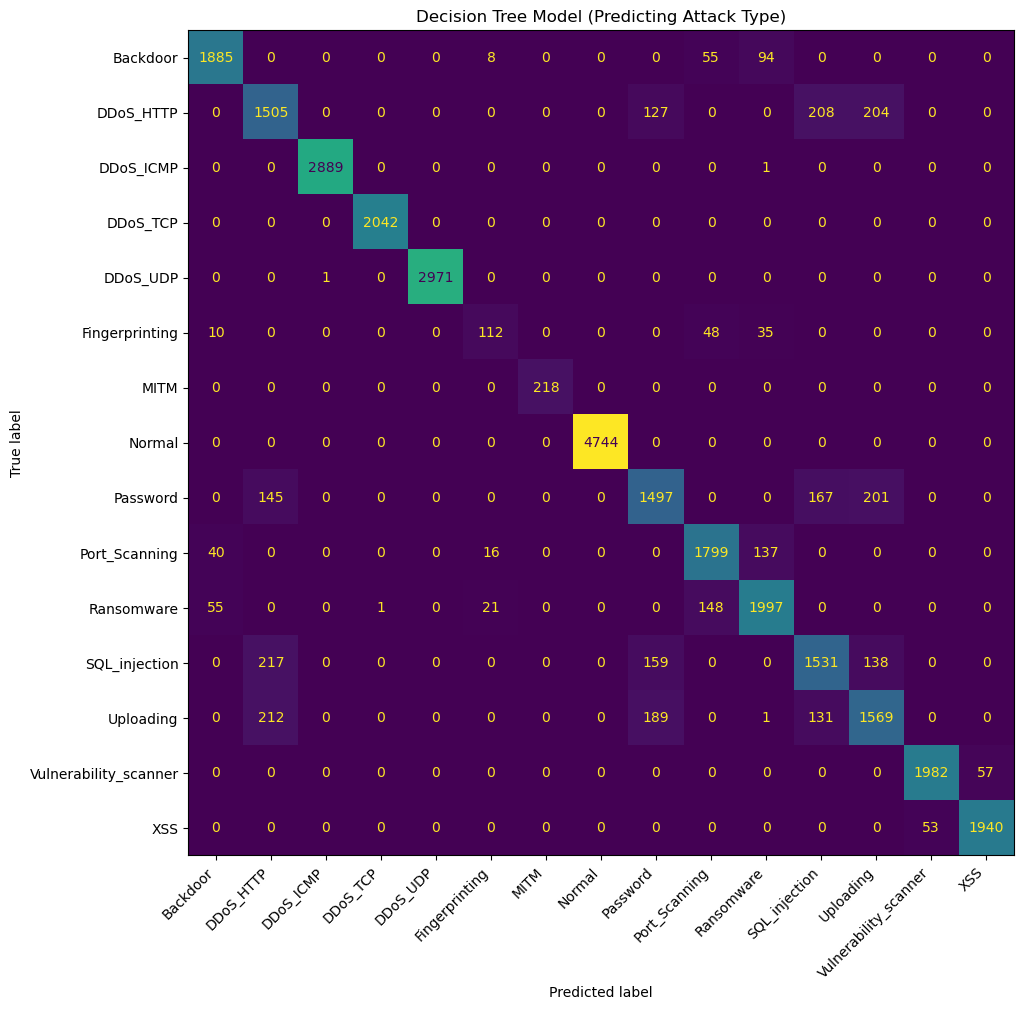

In [190]:
model = DecisionTreeClassifier()

model.fit(x_train, y_train)
pred = model.predict(x_test)
accuracy = accuracy_score(y_test, pred)

print("------ DECISION TREE MODEL ------")
print(f"Accuracy: {accuracy:.4f}")

if target_attack_label:
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    disp = ConfusionMatrixDisplay(confusion_matrix(y_test, pred), display_labels=attack_type_names)
    disp.plot(colorbar=False)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.title('Decision Tree Model (Predicting Attack Label)')
    plt.show()

else:
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test, pred), display_labels=attack_type_names)
    fig, ax = plt.subplots(figsize=(12, 10))
    disp.plot(ax=ax, colorbar=False)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.title('Decision Tree Model (Predicting Attack Type)')
    plt.show()

Depth=1, Accuracy: 0.2356
Depth=2, Accuracy: 0.3271
Depth=3, Accuracy: 0.3971
Depth=4, Accuracy: 0.4618
Depth=5, Accuracy: 0.5820
Depth=6, Accuracy: 0.6484
Depth=7, Accuracy: 0.7067
Depth=8, Accuracy: 0.7742
Depth=9, Accuracy: 0.8337
Depth=10, Accuracy: 0.8566
Depth=11, Accuracy: 0.8825
Depth=12, Accuracy: 0.8949
Depth=13, Accuracy: 0.9014
Depth=14, Accuracy: 0.9048


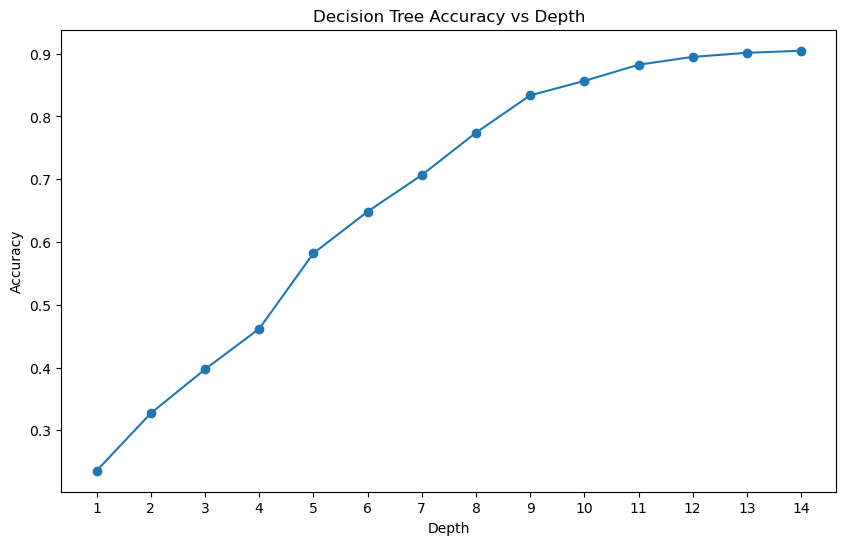

In [191]:
depths = range(1, 15)
# accuracies_train = []
accuracies = []

for depth in depths:

    model = DecisionTreeClassifier(max_depth=depth)

    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, pred)
    # accuracy_train = accuracy_score(y_train, model.predict(x_train))
    accuracies.append(accuracy)
    # accuracies_train.append(accuracy_train)

    print(f"Depth={depth}, Accuracy: {accuracy:.4f}")

# Plotting the accuracy for different values of k
plt.figure(figsize=(10, 6))
plt.plot(depths, accuracies, marker='o')
# plt.plot(depths, accuracies_train, marker='x', linestyle='--')
plt.title('Decision Tree Accuracy vs Depth')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.xticks(depths)
plt.show()

------ BAGGED DECISION TREE MODEL ------
Accuracy: 0.8890


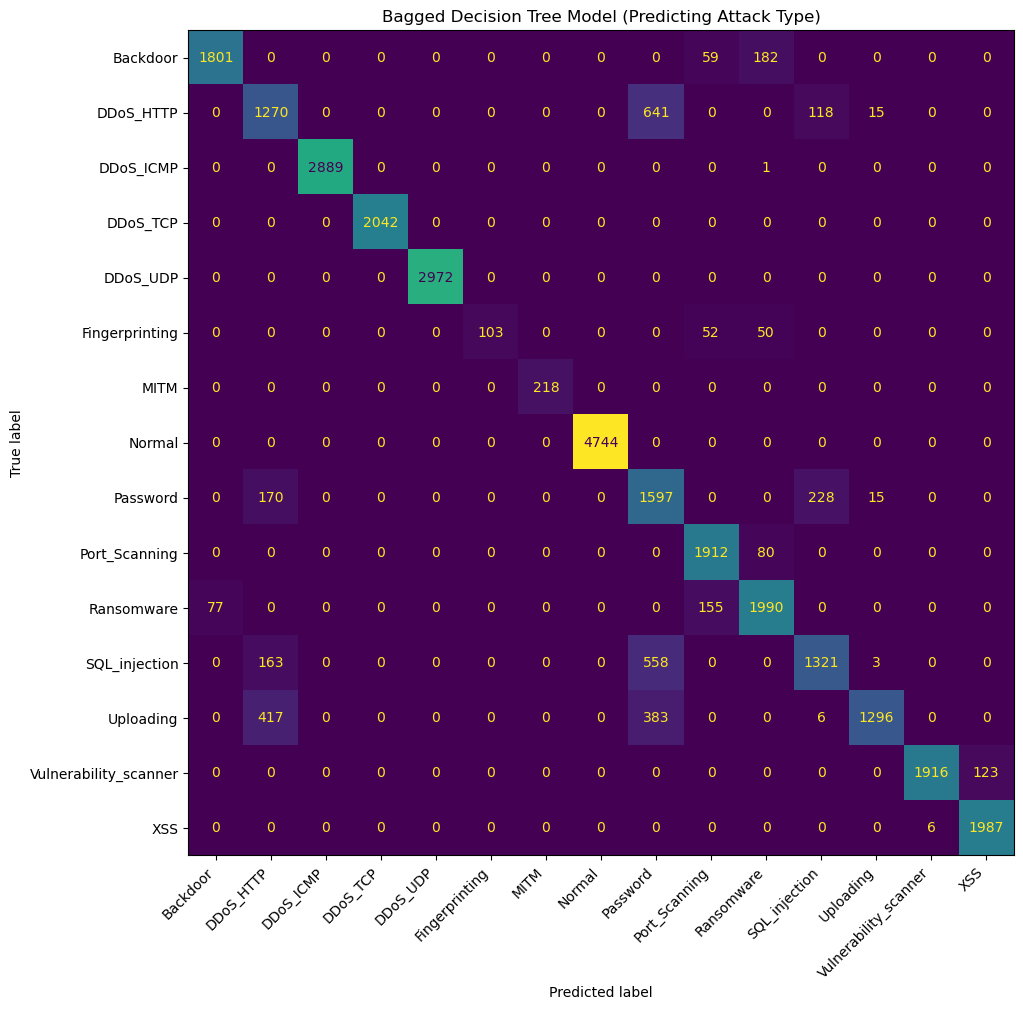

In [192]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(max_depth=10)

model.fit(x_train, y_train)
pred = model.predict(x_test)
accuracy = accuracy_score(y_test, pred)

print("------ BAGGED DECISION TREE MODEL ------")
print(f"Accuracy: {accuracy:.4f}")

if target_attack_label:
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    disp = ConfusionMatrixDisplay(confusion_matrix(
        y_test, pred), display_labels=attack_type_names)
    disp.plot(colorbar=False)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.title('Bagged Decision Tree Model (Predicting Attack Label)')
    plt.show()

else:
    disp = ConfusionMatrixDisplay(confusion_matrix(
        y_test, pred), display_labels=attack_type_names)
    fig, ax = plt.subplots(figsize=(12, 10))
    disp.plot(ax=ax, colorbar=False)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.title('Bagged Decision Tree Model (Predicting Attack Type)')
    plt.show()

------ BOOSTED DECISION TREE MODEL ------
Accuracy: 0.8987


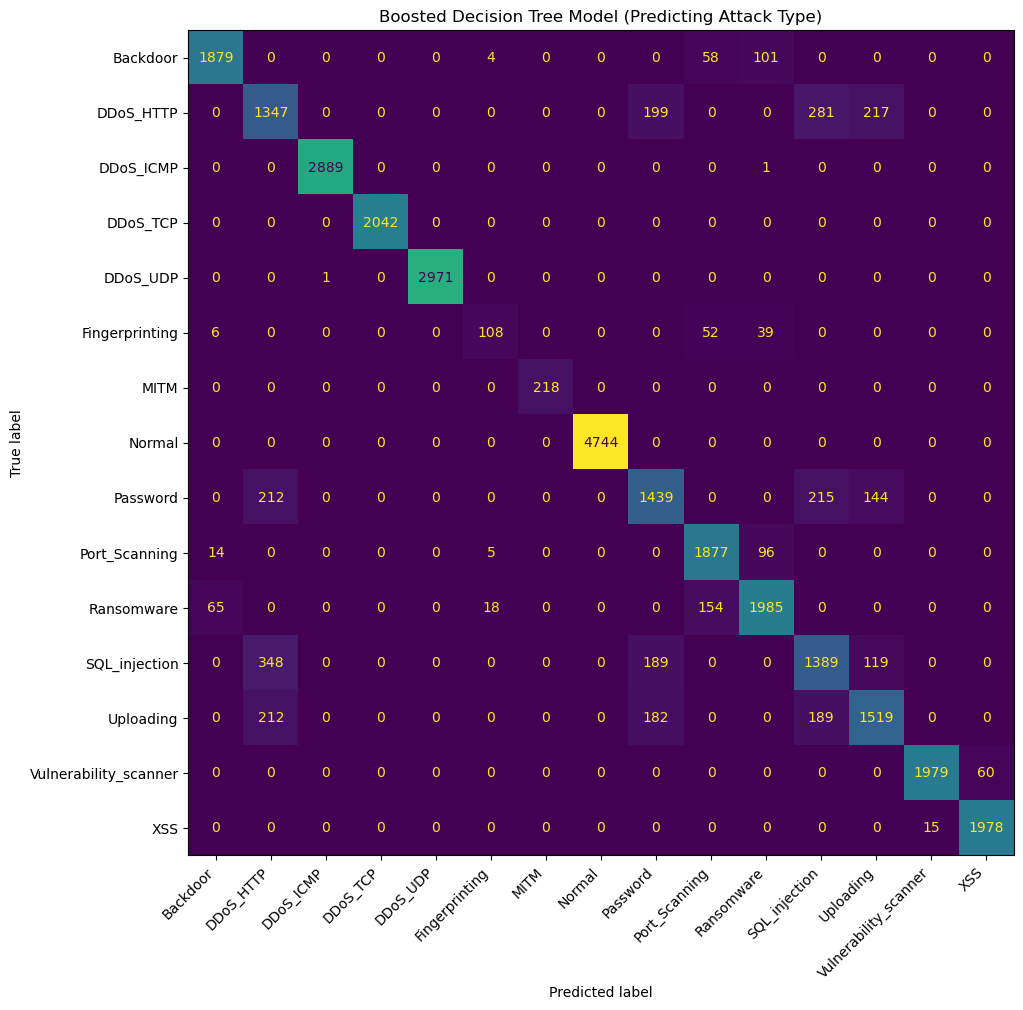

In [193]:
from sklearn.ensemble import AdaBoostClassifier

estimator = DecisionTreeClassifier(max_depth=10)

model = AdaBoostClassifier(estimator=estimator)

model.fit(x_train, y_train)
pred = model.predict(x_test)
accuracy = accuracy_score(y_test, pred)

print("------ BOOSTED DECISION TREE MODEL ------")
print(f"Accuracy: {accuracy:.4f}")

if target_attack_label:
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    disp = ConfusionMatrixDisplay(confusion_matrix(
        y_test, pred), display_labels=attack_type_names)
    disp.plot(colorbar=False)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.title('Boosted Decision Tree Model (Predicting Attack Label)')
    plt.show()

else:
    disp = ConfusionMatrixDisplay(confusion_matrix(
        y_test, pred), display_labels=attack_type_names)
    fig, ax = plt.subplots(figsize=(12, 10))
    disp.plot(ax=ax, colorbar=False)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.title('Boosted Decision Tree Model (Predicting Attack Type)')
    plt.show()

### __Unsupervised Learning__

In [194]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, adjusted_rand_score, normalized_mutual_info_score
from scipy.stats import mode

In [397]:
# Standardise the features (already standardised)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
X_scaled = X

# Load true labels separately (for evaluation only)
true_labels = df['Attack_label'].iloc[df.index]
le_labels = LabelEncoder()
y_true = le_labels.fit_transform(true_labels)


# Helper: map clusters to true labels
def map_clusters_to_labels(clusters, true_labels):
    labels = np.zeros_like(clusters)
    for i in range(len(np.unique(clusters))):
        mask = (clusters == i)
        labels[mask] = mode(true_labels[mask], keepdims=True).mode[0]
    return labels

KMeans Accuracy: 0.8539, ARI: 0.0694


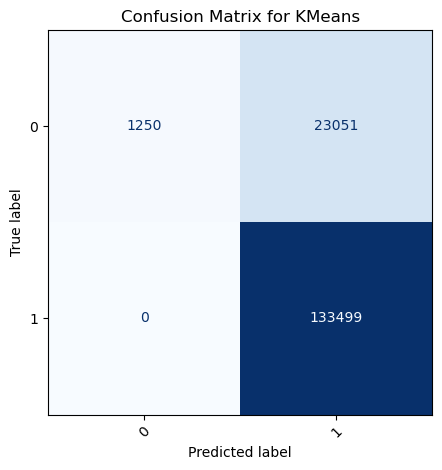

In [196]:
# --- KMeans ---
kmeans = KMeans(n_clusters=len(np.unique(y_true)), random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)
kmeans_mapped = map_clusters_to_labels(kmeans_labels, y_true)
kmeans_acc = accuracy_score(y_true, kmeans_mapped)
kmeans_ari = adjusted_rand_score(y_true, kmeans_labels)
print(f"KMeans Accuracy: {kmeans_acc:.4f}, ARI: {kmeans_ari:.4f}")

cm = confusion_matrix(y_true, kmeans_mapped)

# Create the display object and plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation=45, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix for KMeans")
plt.grid(False)
plt.tight_layout()
plt.show()

Hierarchical Accuracy: 0.7623, ARI: 0.0390


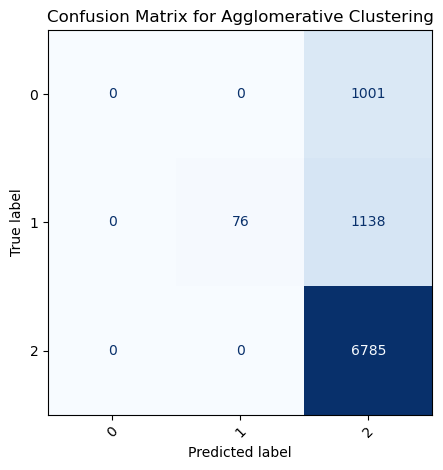

In [197]:
# --- Agglomerative Clustering ---  (sampled for performance)
sample_size = min(9000, len(X_scaled))
X_sample = X_scaled[:sample_size]
y_sample = y[:sample_size]

hclust = AgglomerativeClustering(n_clusters=len(np.unique(y_true)))
hclust_labels = hclust.fit_predict(X_sample)
hclust_mapped = map_clusters_to_labels(hclust_labels, y_sample)
hclust_acc = accuracy_score(y_sample, hclust_mapped)
hclust_ari = adjusted_rand_score(y_sample, hclust_labels)
print(f"Hierarchical Accuracy: {hclust_acc:.4f}, ARI: {hclust_ari:.4f}")

cm = confusion_matrix(y_sample, hclust_mapped)

# Create the display object and plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation=45, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix for Agglomerative Clustering")
plt.grid(False)
plt.tight_layout()
plt.show()

Gaussian Mixture Accuracy: 0.8557, ARI: 0.2066, NMI: 0.0926


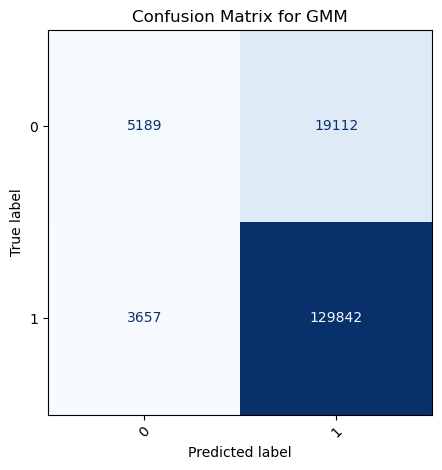

In [214]:
# --- Gaussian Mixture Model ---
gmm = GaussianMixture(n_components=len(np.unique(y_true)),
                      random_state=42, covariance_type='spherical', n_init=5, tol=1e-4, max_iter=1000)
gmm_labels = gmm.fit_predict(X_scaled)
gmm_mapped = map_clusters_to_labels(gmm_labels, y_true)
gmm_acc = accuracy_score(y_true, gmm_mapped)
gmm_ari = adjusted_rand_score(y_true, gmm_labels)
nmi = normalized_mutual_info_score(true_labels, gmm_labels)
print(f"Gaussian Mixture Accuracy: {gmm_acc:.4f}, ARI: {gmm_ari:.4f}, NMI: {nmi:.4f}")

cm = confusion_matrix(y_true, gmm_mapped)

# Create the display object and plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation=45, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix for GMM")
plt.grid(False)
plt.tight_layout()
plt.show()

## __Redoing Unsupervised Models With Dimensionality Reduction__

In [398]:
X_scaled = X

In [399]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4, random_state=42)
X_temp = pca.fit_transform(X_scaled)
print(f"Reduced dimensions: {X_temp.shape[1]} components retained")

Reduced dimensions: 4 components retained


In [400]:
X_scaled = X_temp

Gaussian Mixture Accuracy: 0.9855, ARI: 0.9262, NMI: 0.8370


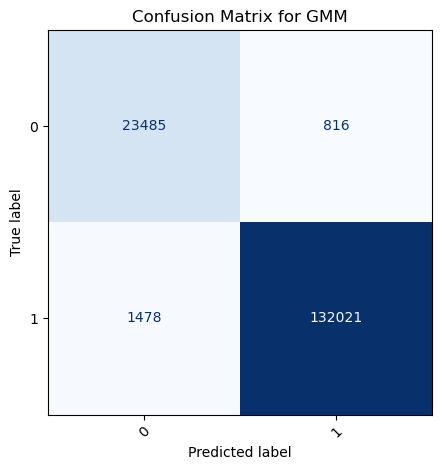

In [401]:
# --- Gaussian Mixture Model ---
gmm = GaussianMixture(n_components=len(np.unique(y_true)),
                      random_state=42, covariance_type='spherical', n_init=5, tol=1e-4, max_iter=1000)
gmm_labels = gmm.fit_predict(X_scaled)
gmm_mapped = map_clusters_to_labels(gmm_labels, y_true)
gmm_acc = accuracy_score(y_true, gmm_mapped)
gmm_ari = adjusted_rand_score(y_true, gmm_labels)
nmi = normalized_mutual_info_score(true_labels, gmm_labels)
print(
    f"Gaussian Mixture Accuracy: {gmm_acc:.4f}, ARI: {gmm_ari:.4f}, NMI: {nmi:.4f}")

cm = confusion_matrix(y_true, gmm_mapped)

# Create the display object and plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation=45, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix for GMM")
plt.grid(False)
plt.tight_layout()
plt.show()

Hierarchical Accuracy: 0.7687, ARI: 0.4796


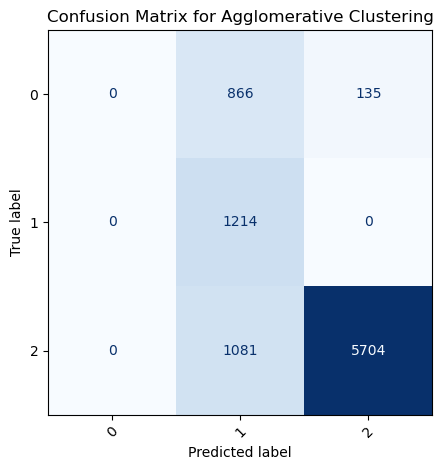

In [331]:
# --- Agglomerative Clustering ---  (sampled for performance)
sample_size = min(9000, len(X_scaled))
X_sample = X_scaled[:sample_size]
y_sample = y[:sample_size]

hclust = AgglomerativeClustering(n_clusters=len(np.unique(y_true)))
hclust_labels = hclust.fit_predict(X_sample)
hclust_mapped = map_clusters_to_labels(hclust_labels, y_sample)
hclust_acc = accuracy_score(y_sample, hclust_mapped)
hclust_ari = adjusted_rand_score(y_sample, hclust_labels)
print(f"Hierarchical Accuracy: {hclust_acc:.4f}, ARI: {hclust_ari:.4f}")

cm = confusion_matrix(y_sample, hclust_mapped)

# Create the display object and plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation=45, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix for Agglomerative Clustering")
plt.grid(False)
plt.tight_layout()
plt.show()

KMeans Accuracy: 0.8539, ARI: 0.0694


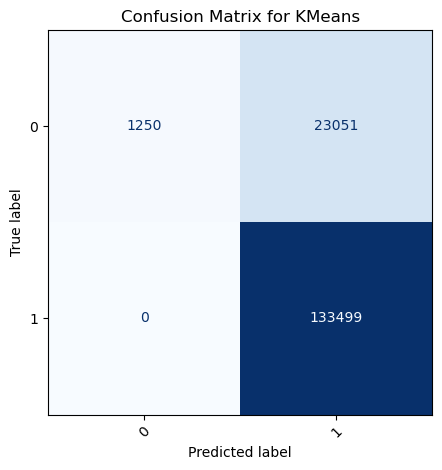

In [343]:
# --- KMeans ---
kmeans = KMeans(n_clusters=len(np.unique(y_true)), random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)
kmeans_mapped = map_clusters_to_labels(kmeans_labels, y_true)
kmeans_acc = accuracy_score(y_true, kmeans_mapped)
kmeans_ari = adjusted_rand_score(y_true, kmeans_labels)
print(f"KMeans Accuracy: {kmeans_acc:.4f}, ARI: {kmeans_ari:.4f}")

cm = confusion_matrix(y_true, kmeans_mapped)

# Create the display object and plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation=45, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix for KMeans")
plt.grid(False)
plt.tight_layout()
plt.show()

### __Neural Network (MLP)__

In [423]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt

Epoch [1/100], Train Loss: 1.7067, Val Loss: 0.9877
Epoch [2/100], Train Loss: 0.8632, Val Loss: 0.7439
Epoch [3/100], Train Loss: 0.7507, Val Loss: 0.6902
Epoch [4/100], Train Loss: 0.7064, Val Loss: 0.6581
Epoch [5/100], Train Loss: 0.6804, Val Loss: 0.6401
Epoch [6/100], Train Loss: 0.6635, Val Loss: 0.6288
Epoch [7/100], Train Loss: 0.6543, Val Loss: 0.6213
Epoch [8/100], Train Loss: 0.6456, Val Loss: 0.6151
Epoch [9/100], Train Loss: 0.6392, Val Loss: 0.6110
Epoch [10/100], Train Loss: 0.6340, Val Loss: 0.6057
Epoch [11/100], Train Loss: 0.6295, Val Loss: 0.6010
Epoch [12/100], Train Loss: 0.6240, Val Loss: 0.5967
Epoch [13/100], Train Loss: 0.6201, Val Loss: 0.5919
Epoch [14/100], Train Loss: 0.6162, Val Loss: 0.5870
Epoch [15/100], Train Loss: 0.6109, Val Loss: 0.5825
Epoch [16/100], Train Loss: 0.6068, Val Loss: 0.5786
Epoch [17/100], Train Loss: 0.6032, Val Loss: 0.5747
Epoch [18/100], Train Loss: 0.5999, Val Loss: 0.5718
Epoch [19/100], Train Loss: 0.5974, Val Loss: 0.5702
Ep

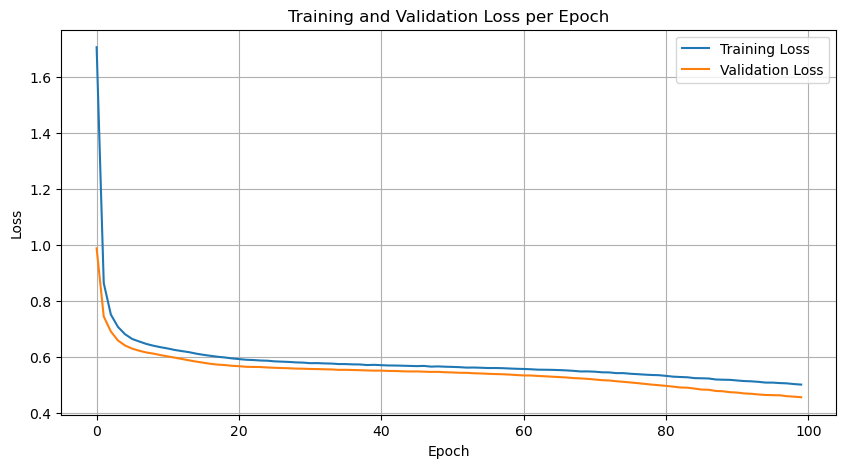

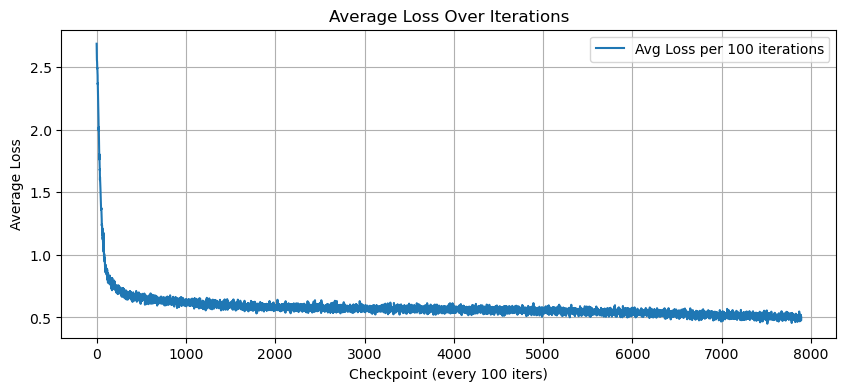

In [424]:
# MLP was done in a differnt notebook (on Google Colab), including it here but may not be the most up to date (slight tweaks to hyperparameters)
y_tensor = torch.tensor(y, dtype=torch.long)

X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
X_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)


class MLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.Sigmoid(),
            # nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.Sigmoid(),
            # nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.model(x)


input_dim = x_train.shape[1]
num_classes = len(np.unique(y))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(input_dim, num_classes).to(device)

# Test different optimisers, learning rates and loss functions
criterion = nn.CrossEntropyLoss()
optimiser = optim.AdamW(model.parameters(), lr=0.0001)

num_epochs = 100
train_losses = []
val_losses = []
iteration_losses = []
iteration_count = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    iteration_loss = []
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimiser.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimiser.step()
        running_loss += loss.item()
        iteration_loss.append(loss.item())
        iteration_count += 1

        if iteration_count % 100 == 0:
            avg_loss = np.mean(iteration_loss)
            # print(f"Iteration {iteration_count}, Average Loss (last 100): {avg_loss:.4f}")
            iteration_losses.append(avg_loss)
            iteration_loss = []

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validate
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)
    print(
        f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# Evaluate
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

print(f"Test Accuracy: {correct / total:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(iteration_losses, label='Avg Loss per 100 iterations')
plt.xlabel('Checkpoint (every 100 iters)')
plt.ylabel('Average Loss')
plt.title('Average Loss Over Iterations')
plt.grid(True)
plt.legend()
plt.show()